In [1]:
# Import packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import os
from scipy.stats import gaussian_kde

In [2]:
# Read in data, print info, and inspect columns visually
data = pd.read_csv("Volumetric_features.csv")
data.info()
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4226 entries, 0 to 4225
Columns: 141 entries, S.No to dataset
dtypes: float64(122), int64(19)
memory usage: 4.5 MB


,S.No,Left-Lateral-Ventricle,Left-Inf-Lat-Vent,Left-Cerebellum-White-Matter,Left-Cerebellum-Cortex,Left-Thalamus,Left-Caudate,Left-Putamen,Left-Pallidum,3rd-Ventricle,...,rh_supramarginal_thickness,rh_frontalpole_thickness,rh_temporalpole_thickness,rh_transversetemporal_thickness,rh_insula_thickness,rh_MeanThickness_thickness,BrainSegVolNotVent.2,eTIV.1,Age,dataset
0,1,22916.9,982.7,15196.7,55796.4,6855.5,2956.4,4240.7,2223.9,2034.4,...,2.408,2.629,3.519,2.009,2.825,2.33635,1093846,1619602.965,85,1
1,2,22953.2,984.5,15289.7,55778.6,6835.1,3064.2,4498.6,2354.1,1927.1,...,2.417,2.640,3.488,2.111,2.720,2.34202,1099876,1624755.130,85,1
2,3,23320.4,1062.1,15382.1,55551.2,7566.0,3231.7,4456.2,1995.4,2064.7,...,2.374,2.601,3.342,2.146,2.684,2.31982,1097999,1622609.518,86,1
3,4,24360.0,1000.5,14805.4,54041.8,8004.6,3137.3,4262.2,1983.4,2017.7,...,2.366,2.639,3.361,2.056,2.700,2.29215,1070117,1583854.236,87,1
4,5,25769.4,1124.4,16331.1,54108.6,6677.4,2964.4,4204.6,2409.7,2251.8,...,2.381,2.555,3.450,2.052,2.574,2.30397,1075926,1617375.362,89,1


In [3]:
# Separate test predictor (age)
x = data.drop(["Age"], axis=1) 
y = data.Age.values

# Drop poor/collinear predictors (based on group analysis)
data.drop('dataset', axis=1, inplace = True)
data.drop('Left-WM-hypointensities', axis=1, inplace = True)
data.drop('Right-WM-hypointensities', axis=1, inplace = True)
data.drop('Left-non-WM-hypointensities', axis=1, inplace = True)
data.drop('Right-non-WM-hypointensities', axis=1, inplace = True)

# Split testing/training data
from sklearn.model_selection import train_test_split 
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42, shuffle = True) 

In [6]:
def plot_prediction(x, y):
    # This function creates a density scatter plot from x and y
    # Code adapted from:
    # https://stackoverflow.com/questions/20105364/how-can-i-make-a-scatter-plot-colored-by-density-in-matplotlib
    
    # Get point density
    xy = np.vstack([x,y])
    z = gaussian_kde(xy)(xy)

    # Plot densest points on top by sorting
    idx = z.argsort()
    x, y, z = x[idx], y[idx], z[idx]
    
    # Plot
    plt.figure()
    plt.xlabel("Predicted y")
    plt.ylabel("True y")
    plt.title("True and Predicted Values of y")
    plt.scatter(x, y, c=z, s=50)
    plt.show()
    

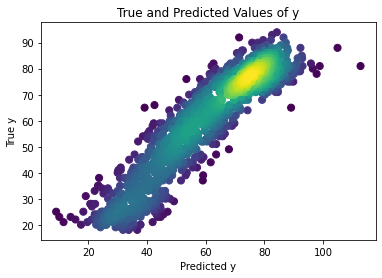

(0.8486697961085404, 7.781587237400794)

In [7]:
# Penalized Model - Ridge Regression

from sklearn import linear_model

def Ridge(plot=True, **kwargs):
    
    # Training
    model = linear_model.Ridge(**kwargs)
    model = model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    
    # Test
    r2 = sk.metrics.r2_score(y_test, y_predict)
    rmse = np.sqrt(sk.metrics.mean_squared_error(y_test, y_predict))
    
    # Plotting
    if plot: # Option to disable plottig (for looping)
        plot_prediction(y_predict, y_test)

    return(r2, rmse)
    
    
Ridge(alpha=7)

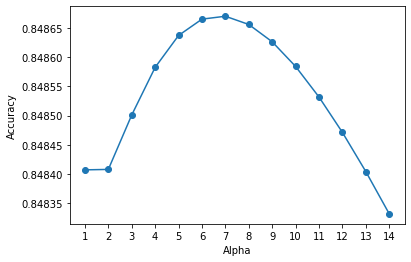

In [8]:
# Loop for optimizing Ridge alpha parameter

# Initialize arrays
alpha = []
accs = []

# Loop over reasonable range of alpha, calculate acc, and append
for i in np.arange(1, 15):
    alpha.append(i)
    (acc, rmse) = Ridge(alpha=i, plot=False)
    accs.append(acc)

# Plot accuracy vs alpha
plt.plot(alpha, accs, '-o')
plt.xticks(np.arange(min(alpha), max(alpha)+1, 1.0))
plt.xlabel('Alpha')
plt.ylabel("Accuracy")
plt.show()

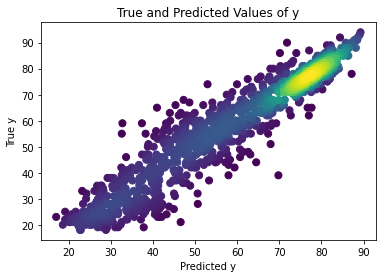

(0.9050537601636167, 6.163739376062851)

In [17]:
# Boosted tree

# Hist seems to work better for some reason, despite n < 10000
from sklearn.ensemble import HistGradientBoostingRegressor

def Boosted(plot=True, **kwargs):
    # Train
    model = HistGradientBoostingRegressor(**kwargs)
    model = model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    
    # Test
    r2 = sk.metrics.r2_score(y_test, y_predict)
    rmse = np.sqrt(sk.metrics.mean_squared_error(y_test, y_predict))
    
    # Plotting
    if plot:
        plot_prediction(y_predict, y_test)
        
    return r2, rmse
        
    
Boosted(loss="squared_error")

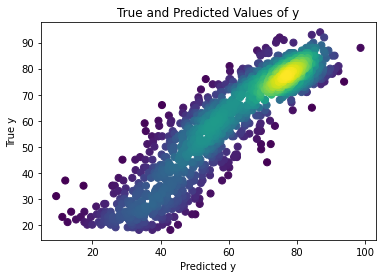

(0.8238630839227749, 8.395190899096825)

In [10]:
# Support Vector Machine

from sklearn import svm

def SVM(plot=True, **kwargs):
    # Train
    model = svm.SVR(**kwargs)
    model = model.fit(x_train, y_train)
    y_predict = model.predict(x_test)
    
    # Test
    r2 = sk.metrics.r2_score(y_test, y_predict)
    rmse = np.sqrt(sk.metrics.mean_squared_error(y_test, y_predict))
    
    # Plotting
    if plot:
        plot_prediction(y_predict, y_test)
        
    return(r2, rmse)
    
    
SVM(kernel='poly', degree=5, coef0=23)

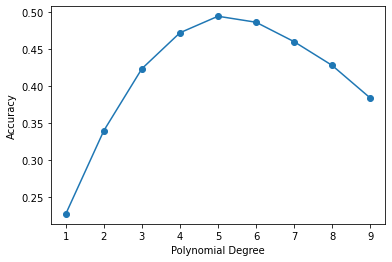

In [11]:
# Loop for optimizing SVM polynomial degree

# Initialize arrays
degree = []
accs = []

# Loop over reasonable degree values, calculate accuracy, and append
for i in np.arange(1, 10):
    degree.append(i)
    (acc, rmse) = SVM(kernel='poly', degree=i, plot=False)
    accs.append(acc)

# Plot accuracy vs degree
plt.plot(degree, accs, '-o')
plt.xticks(np.arange(min(degree), max(degree)+1, 1.0))
plt.xlabel('Polynomial Degree')
plt.ylabel("Accuracy")
plt.show()

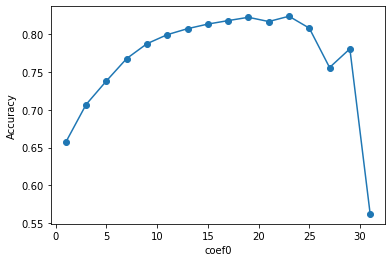

In [13]:
# Loop for optimizing SVM polynomial coefficient

# Initialize arrays
coef0 = []
accs = []

# Loop over reasonable coef0 values, calculate accuracy, and append
for i in np.arange(1, 32, 2):
    coef0.append(i)
    (acc, rmse) = SVM(kernel='poly', degree=5, coef0=i, plot=False)
    accs.append(acc)

# Plot accuracy vs coef0
plt.plot(coef0, accs, '-o')
plt.xlabel('coef0')
plt.ylabel("Accuracy")
plt.show()